In [1]:
import pandas as pd
import numpy as np
from matplotlib import colors, cm, text, pyplot as plt
import matplotlib.patches as patches

In [2]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [3]:
import peakutils
from scipy import signal
import math

In [4]:
raw_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/YHE211_1-mz-748-766-rt-2000-2200.pkl')
raw_df = raw_df[(raw_df.frame_type == 0) & (raw_df.intensity >= 50)]
raw_df.reset_index(drop=True, inplace=True)

In [5]:
# assign each point a unique identifier
raw_df['point_id'] = raw_df.index

In [6]:
raw_df.head()

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,point_id
0,18187,0,748.002161,765,81,2028.860792,0
1,18987,0,748.002161,627,93,2113.537640,1
2,18987,0,748.002161,648,62,2113.537640,2
3,18972,0,748.002161,657,66,2111.950076,3
4,18987,0,748.002161,675,132,2113.537640,4


In [7]:
# find the most intense point
anchor_point_s = raw_df.loc[raw_df.intensity.idxmax()]
anchor_point_s

frame_id                19352.000000
frame_type                  0.000000
mz                        750.393146
scan                      545.000000
intensity                3099.000000
retention_time_secs      2152.173452
point_id               177399.000000
Name: 177399, dtype: float64

In [8]:
mz_lower = anchor_point_s.mz - 1.0
mz_upper = anchor_point_s.mz + 7.0
scan_lower = anchor_point_s.scan - 100
scan_upper = anchor_point_s.scan + 100

In [9]:
candidate_region_df = raw_df[(raw_df.frame_id == anchor_point_s.frame_id) & (raw_df.mz >= mz_lower) & (raw_df.mz <= mz_upper) & (raw_df.scan >= scan_lower) & (raw_df.scan <= scan_upper)].copy()


In [10]:
MS1_PEAK_DELTA = 0.1

In [11]:
peak_mz_lower = anchor_point_s.mz-MS1_PEAK_DELTA
peak_mz_upper = anchor_point_s.mz+MS1_PEAK_DELTA

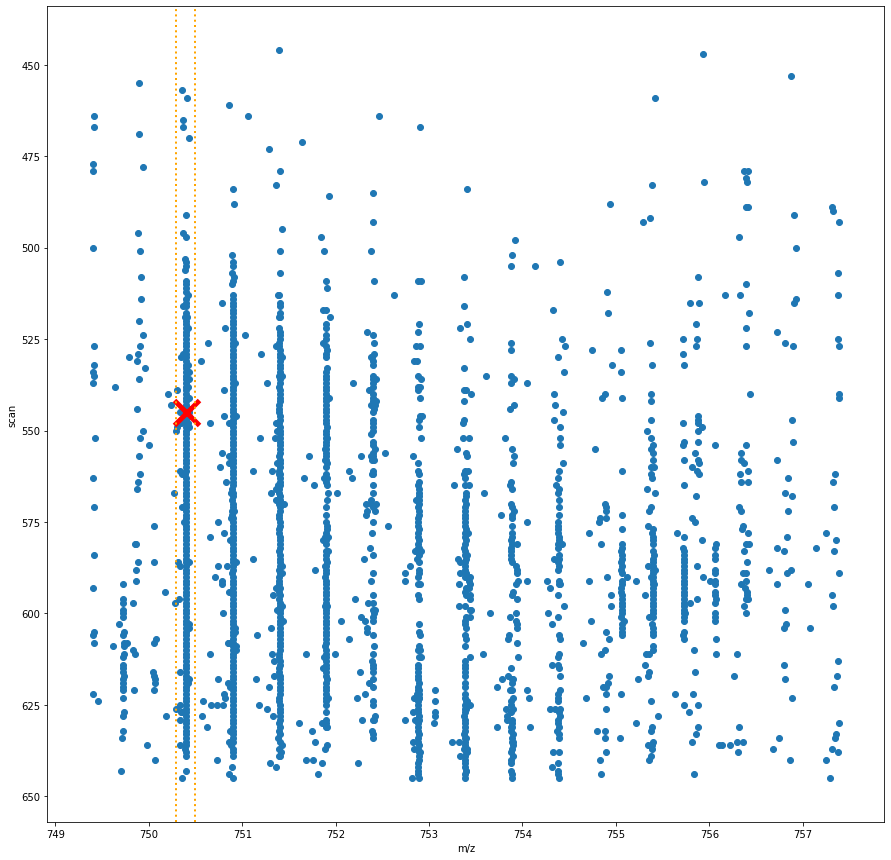

In [12]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(candidate_region_df.mz, candidate_region_df.scan)
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=5, ms=25, label='anchor point')

plt.axvline(x=peak_mz_lower, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=peak_mz_upper, linestyle=':', color='orange', linewidth=2)

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

In [13]:
peak_df = candidate_region_df[(candidate_region_df.mz >= peak_mz_lower) & (candidate_region_df.mz <= peak_mz_upper)]

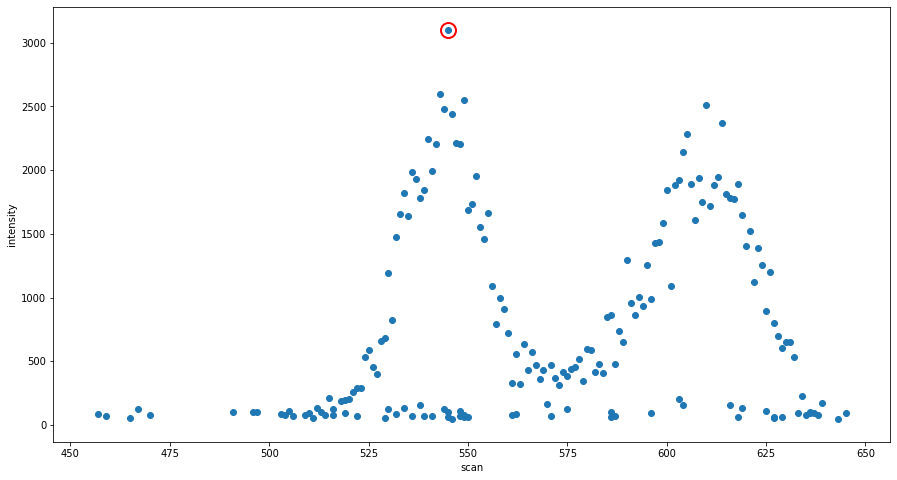

In [14]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(peak_df.scan, peak_df.intensity)
plt.plot(anchor_point_s.scan, anchor_point_s.intensity, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15, label='anchor point')

plt.xlabel("scan")
plt.ylabel("intensity")
plt.show()

In [15]:
scan_0_df = peak_df.groupby(['scan'], as_index=False).intensity.sum()
scan_0_df.sort_values(by=['scan'], ascending=True, inplace=True)
# filter the points
scan_0_df['filtered_intensity'] = scan_0_df.intensity  # set the default
window_length = 21
if len(scan_0_df) > window_length:
    try:
        scan_0_df['filtered_intensity'] = signal.savgol_filter(scan_0_df.intensity, window_length=window_length, polyorder=2)
        filtered = True
    except:
        filtered = False
else:
    filtered = False

In [16]:
filtered

True

In [17]:
peak_idxs = peakutils.indexes(scan_0_df.filtered_intensity.values, thres=0.05, min_dist=10/2, thres_abs=False)
peak_x_l = scan_0_df.iloc[peak_idxs].scan.to_list()
peaks_df = scan_0_df[scan_0_df.scan.isin(peak_x_l)]

In [18]:
valley_idxs = peakutils.indexes(-scan_0_df.filtered_intensity.values, thres=0.05, min_dist=10/2, thres_abs=False)
valley_x_l = scan_0_df.iloc[valley_idxs].scan.to_list()
valleys_df = scan_0_df[scan_0_df.scan.isin(valley_x_l)]

In [19]:
valleys_df

,scan,intensity,filtered_intensity
7,497,103,76.064739
70,568,364,384.944753
78,576,442,390.732592


In [20]:
upper_x = valleys_df[valleys_df.scan > anchor_point_s.scan].scan.min()
if math.isnan(upper_x):
    upper_x = flattened_points_df.scan.max()
lower_x = valleys_df[valleys_df.scan < anchor_point_s.scan].scan.max()
if math.isnan(lower_x):
    lower_x = flattened_points_df.scan.min()

In [21]:
scan_0_extract_df = scan_0_df[(scan_0_df.scan >= lower_x) & (scan_0_df.scan <= upper_x)]

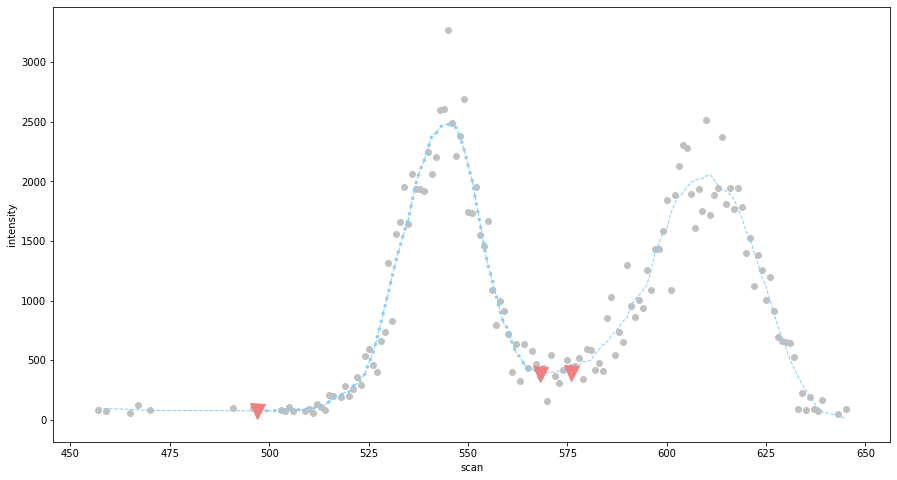

In [22]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(scan_0_df.scan, scan_0_df.intensity, c='silver')
# plot the smoothed points
plt.plot(scan_0_df.scan, scan_0_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')
plt.plot(scan_0_extract_df.scan, scan_0_extract_df.filtered_intensity, marker='', color='lightskyblue', linestyle=':', linewidth=3, ms=5, label='extracted')

plt.plot(valleys_df.scan, valleys_df.filtered_intensity, marker='v', color='lightcoral', linestyle=None, linewidth=0, ms=15, label='valleys')


plt.xlabel("scan")
plt.ylabel("intensity")
plt.show()

#### trim the candidate region to account for the selected peak in mobility

In [23]:
candidate_region_df = candidate_region_df[(candidate_region_df.scan >= lower_x) & (candidate_region_df.scan <= upper_x)]

#### segment the raw data to reveal the isotopes in the feature

In [24]:
X = candidate_region_df[['mz','scan']].values

In [25]:
def custom_metric(r1, r2):
    mz_1 = r1[0]
    scan_1 = r1[1]
    mz_2 = r2[0]
    scan_2 = r2[1]
    if (abs(mz_1 - mz_2) <= 0.1) and (abs(scan_1 - scan_2) <= 2):
        result = 0.5
    else:
        result = 10
    return result;

In [26]:
# cluster the data
dbscan = DBSCAN(eps=1, min_samples=3, metric=custom_metric)
clusters = dbscan.fit_predict(X)

In [27]:
candidate_region_df['cluster'] = clusters

In [28]:
candidate_region_df.sample(n=5)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,point_id,cluster
321904,19352,0,752.430846,542,70,2152.173452,321904,12
206200,19352,0,750.895866,556,1051,2152.173452,206200,6
449955,19352,0,754.355007,565,54,2152.173452,449955,26
560574,19352,0,755.880583,547,76,2152.173452,560574,29
371312,19352,0,753.330204,522,70,2152.173452,371312,-1


In [29]:
print('found {} clusters'.format(len(candidate_region_df.cluster.unique())))

found 32 clusters


In [30]:
colour_map = plt.get_cmap('gist_ncar')
norm = colors.Normalize(vmin=candidate_region_df.cluster.min(), vmax=candidate_region_df.cluster.max(), clip=False)

In [31]:
# calculate the cluster centroids
centroids_l = []
for group_name,group_df in candidate_region_df.groupby(['cluster'], as_index=False):
    if group_name >= 0:
        mz_centroid = peakutils.centroid(group_df.mz, group_df.intensity)
        scan_centroid = peakutils.centroid(group_df.scan, group_df.intensity)
        centroids_l.append((group_name, mz_centroid, scan_centroid))
centroids_df = pd.DataFrame(centroids_l, columns=['cluster','mz','scan'])

In [32]:
# determine a colour for each cluster
cluster_colour_l = []
for group_name,group_df in candidate_region_df.groupby(['cluster'], as_index=False):
    c = colour_map(norm(group_name), bytes=False)[:3]
    cluster_colour_l.append((group_name, c))
cluster_colour_df = pd.DataFrame(cluster_colour_l, columns=['cluster','colour'])

In [33]:
# give each point a colour
candidate_region_df = pd.merge(candidate_region_df, cluster_colour_df, how='left', left_on=['cluster'], right_on=['cluster'])


In [34]:
candidate_region_df.sample(n=3)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,point_id,cluster,colour
473,19352,0,754.850435,541,61,2152.173452,485598,-1,"(0.0, 0.0, 0.502)"
288,19352,0,751.897510,527,90,2152.173452,274049,10,"(0.2747411764705878, 0.8670201614763554, 0.0)"
99,19352,0,750.401738,510,92,2152.173452,180309,4,"(0.0, 0.7535652589240823, 1.0)"


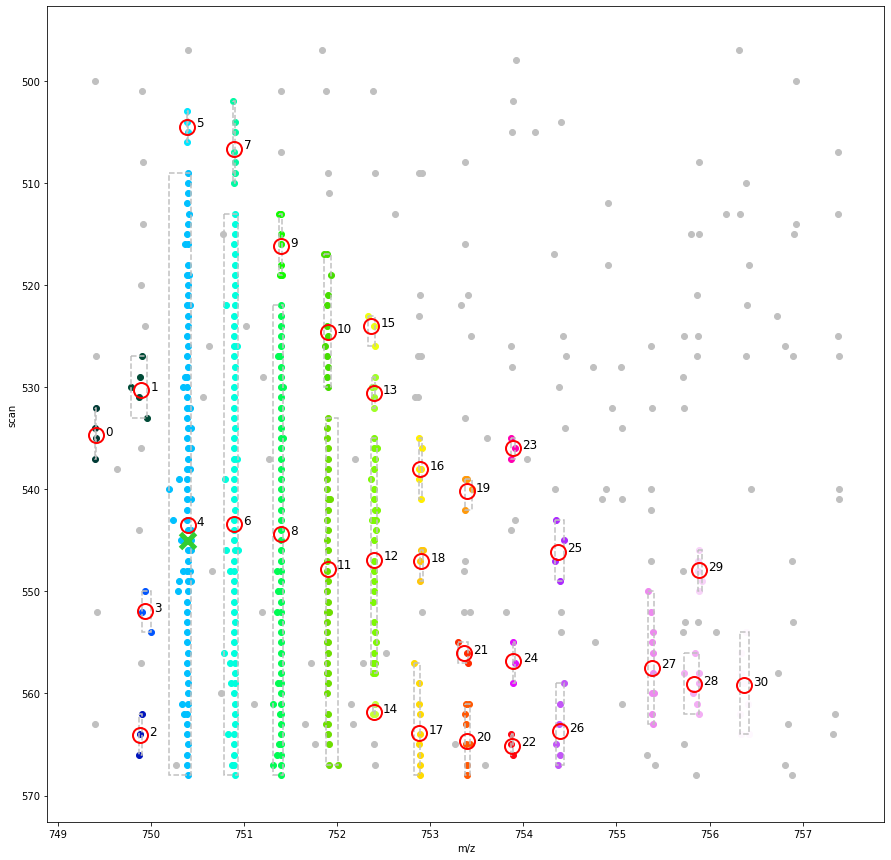

In [35]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

# plot the unassigned points
df = candidate_region_df[(candidate_region_df.cluster == -1)]
plt.scatter(df.mz, df.scan, c='silver')

df = candidate_region_df[(candidate_region_df.cluster >= 0)]
for group_name,group_df in df.groupby(['cluster'], as_index=False):
    # the raw points
    plt.scatter(group_df.mz, group_df.scan, c=np.array([group_df.iloc[0].colour]))
    # the cluster centroid
    centroid_s = centroids_df[(centroids_df.cluster == group_name)].iloc[0]
    plt.plot(centroid_s.mz, centroid_s.scan, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15)
    ax1.text(centroid_s.mz+0.1, centroid_s.scan, group_name, fontsize=12)
    # draw the cluster rectangle
    top_left = (group_df.mz.min(),group_df.scan.min())
    width = group_df.mz.max() - group_df.mz.min()
    height = group_df.scan.max() - group_df.scan.min()
    cluster_rect = patches.Rectangle(top_left,width,height,linewidth=1.5,linestyle='--',edgecolor='silver',facecolor='none')
    ax1.add_patch(cluster_rect)

# the anchor point for this candidate region
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='limegreen', linestyle='', markeredgewidth=5, ms=15, label='anchor point')

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

In [36]:
def isotope_metric(r1, r2):
    mz_1 = r1[0]
    scan_1 = r1[1]
    mz_2 = r2[0]
    scan_2 = r2[1]
    if (abs(mz_1 - mz_2) <= 1.0) and (abs(mz_1 - mz_2) > 0.1) and (abs(scan_1 - scan_2) <= 5):
        result = 0.5
    else:
        result = 10
    return result;

In [37]:
X = centroids_df[['mz','scan']].values

In [38]:
# cluster the data
dbscan = DBSCAN(eps=1, min_samples=2, metric=isotope_metric)
clusters = dbscan.fit_predict(X)
centroids_df['isotope_cluster'] = clusters

In [39]:
print('found {} isotope clusters'.format(len(centroids_df.isotope_cluster.unique())))

found 5 isotope clusters


In [40]:
candidate_region_df = pd.merge(candidate_region_df, centroids_df[['cluster','isotope_cluster']], how='left', left_on=['cluster'], right_on=['cluster'])


In [41]:
candidate_region_df.fillna(value=-1, inplace=True)
candidate_region_df.isotope_cluster = candidate_region_df.isotope_cluster.astype(int)

In [42]:
candidate_region_df.sample(n=3)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,point_id,cluster,colour,isotope_cluster
530,19352,0,756.329067,513,55,2152.173452,582958,-1,"(0.0, 0.0, 0.502)",-1
224,19352,0,751.394455,557,422,2152.173452,242311,8,"(0.0, 0.9885719816437213, 0.32763514098338886)",0
124,19352,0,750.805621,546,52,2152.173452,194458,6,"(0.0, 0.9964395250443565, 0.8713071728691479)",0


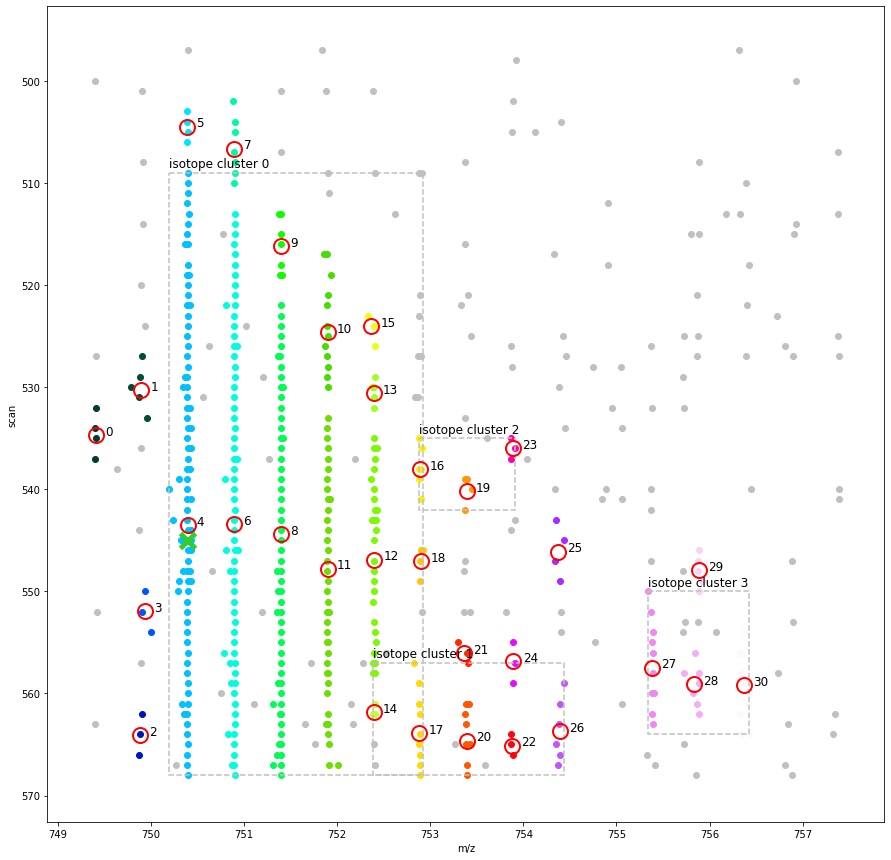

In [43]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

# plot the unassigned points
df = candidate_region_df[(candidate_region_df.cluster == -1)]
plt.scatter(df.mz, df.scan, c='silver')

df = candidate_region_df[(candidate_region_df.cluster >= 0)]
for group_name,group_df in df.groupby(['cluster'], as_index=False):
    # the raw points
    plt.scatter(group_df.mz, group_df.scan, c=np.array([group_df.iloc[0].colour]))
    # the cluster centroid
    centroid_s = centroids_df[(centroids_df.cluster == group_name)].iloc[0]
    plt.plot(centroid_s.mz, centroid_s.scan, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15)
    ax1.text(centroid_s.mz+0.1, centroid_s.scan, group_name, fontsize=12)

df = candidate_region_df[(candidate_region_df.isotope_cluster >= 0)]
for group_name,group_df in df.groupby(['isotope_cluster'], as_index=False):
    # draw the cluster rectangle
    top_left = (group_df.mz.min(),group_df.scan.min())
    width = group_df.mz.max() - group_df.mz.min()
    height = group_df.scan.max() - group_df.scan.min()
    cluster_rect = patches.Rectangle(top_left,width,height,linewidth=1.5,linestyle='--',edgecolor='silver',facecolor='none')
    ax1.add_patch(cluster_rect)
    ax1.text(top_left[0], top_left[1]-0.5, 'isotope cluster {}'.format(int(group_name)), fontsize=12)

# the anchor point for this candidate region
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='limegreen', linestyle='', markeredgewidth=5, ms=15, label='anchor point')

plot_xlim = ax1.get_xlim()
plot_ylim = ax1.get_ylim()

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

#### we now have the 2D extent of the feature - take that extent through time and see if we can cluster the centroids in time

In [44]:
# which cluster contains the anchor point?
anchor_point_s = candidate_region_df[(candidate_region_df.point_id == anchor_point_s.point_id)].iloc[0]


In [45]:
anchor_point_s

frame_id                                        19352
frame_type                                          0
mz                                            750.393
scan                                              545
intensity                                        3099
retention_time_secs                           2152.17
point_id                                       177399
cluster                                             4
colour                 (0.0, 0.7535652589240823, 1.0)
isotope_cluster                                     0
Name: 63, dtype: object

In [46]:
# get the extent of the isotope cluster in m/z and mobility
points_in_cluster_df = candidate_region_df[(candidate_region_df.isotope_cluster == anchor_point_s.isotope_cluster)]
mz_lower = points_in_cluster_df.mz.min()
mz_upper = points_in_cluster_df.mz.max()
scan_lower = points_in_cluster_df.scan.min()
scan_upper = points_in_cluster_df.scan.max()

In [47]:
RT_BASE_PEAK_WIDTH = 10

In [48]:
# get the left-most peak in the isotope cluster
monoisotopic_cluster_s = centroids_df.loc[centroids_df[(centroids_df.isotope_cluster == anchor_point_s.isotope_cluster)].mz.idxmin()]


In [49]:
mono_raw_points_df = raw_df[(raw_df.mz >= monoisotopic_cluster_s.mz-MS1_PEAK_DELTA) & (raw_df.mz <= monoisotopic_cluster_s.mz+MS1_PEAK_DELTA) & (raw_df.scan >= scan_lower) & (raw_df.scan <= scan_upper) & (raw_df.retention_time_secs >= anchor_point_s.retention_time_secs-RT_BASE_PEAK_WIDTH) & (raw_df.retention_time_secs <= anchor_point_s.retention_time_secs+RT_BASE_PEAK_WIDTH)]
rt_0_df = mono_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
rt_0_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
# filter the points
rt_0_df['filtered_intensity'] = rt_0_df.intensity  # set the default
window_length = 11
if len(rt_0_df) > window_length:
    try:
        rt_0_df['filtered_intensity'] = signal.savgol_filter(rt_0_df.intensity, window_length=window_length, polyorder=3)
        filtered = True
    except:
        filtered = False
else:
    filtered = False

In [50]:
filtered

True

In [51]:
peak_idxs = peakutils.indexes(rt_0_df.filtered_intensity.values, thres=0.05, min_dist=10/2, thres_abs=False)
peak_x_l = rt_0_df.iloc[peak_idxs].retention_time_secs.to_list()
peaks_df = rt_0_df[rt_0_df.retention_time_secs.isin(peak_x_l)]

In [52]:
valley_idxs = peakutils.indexes(-rt_0_df.filtered_intensity.values, thres=0.05, min_dist=10/8, thres_abs=False)
valley_x_l = rt_0_df.iloc[valley_idxs].retention_time_secs.to_list()
valleys_df = rt_0_df[rt_0_df.retention_time_secs.isin(valley_x_l)]

In [53]:
valleys_df

,frame_id,retention_time_secs,intensity,filtered_intensity
5,19287,2145.294785,491,696.293706
26,19392,2156.406630,1030,-381.365967
30,19412,2158.523892,393,318.934732


In [54]:
upper_x = valleys_df[valleys_df.retention_time_secs > anchor_point_s.retention_time_secs].retention_time_secs.min()
if math.isnan(upper_x):
    upper_x = flattened_points_df.retention_time_secs.max()
lower_x = valleys_df[valleys_df.retention_time_secs < anchor_point_s.retention_time_secs].retention_time_secs.max()
if math.isnan(lower_x):
    lower_x = flattened_points_df.retention_time_secs.min()

In [59]:
rt_lower = lower_x
rt_upper = upper_x

In [60]:
rt_0_extract_df = rt_0_df[(rt_0_df.retention_time_secs >= lower_x) & (rt_0_df.retention_time_secs <= upper_x)]

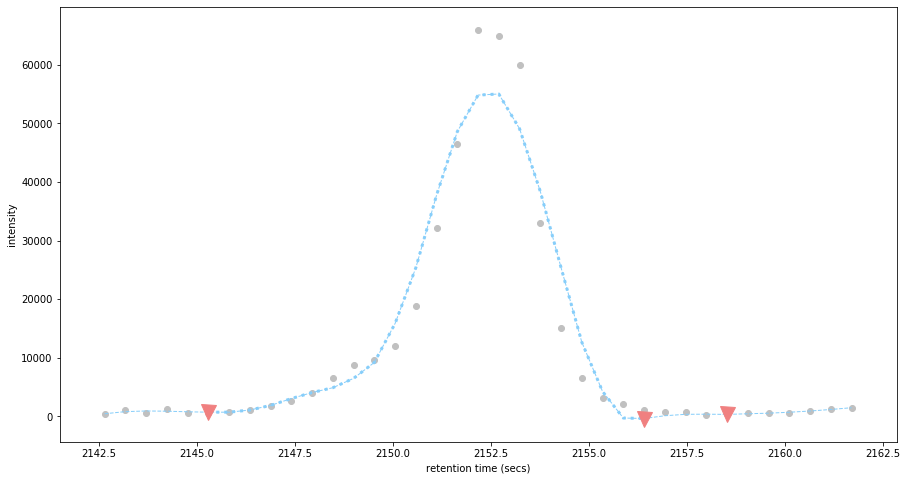

In [61]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(rt_0_df.retention_time_secs, rt_0_df.intensity, c='silver')
# plot the smoothed points
plt.plot(rt_0_df.retention_time_secs, rt_0_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')
plt.plot(rt_0_extract_df.retention_time_secs, rt_0_extract_df.filtered_intensity, marker='', color='lightskyblue', linestyle=':', linewidth=3, ms=5, label='extracted')

plt.plot(valleys_df.retention_time_secs, valleys_df.filtered_intensity, marker='v', color='lightcoral', linestyle=None, linewidth=0, ms=15, label='valleys')

plt.xlabel("retention time (secs)")
plt.ylabel("intensity")
plt.show()

In [64]:
# set the intensity to zero for all points in the candidate region points
raw_df.loc[(raw_df.retention_time_secs >= rt_lower) & (raw_df.retention_time_secs <= rt_upper) & (raw_df.mz >= mz_lower) & (raw_df.mz <= mz_upper) & (raw_df.scan >= scan_lower) & (raw_df.scan <= scan_upper), 'intensity'] = 10

In [65]:
len(raw_df[(raw_df.intensity == 10)])

4665